In [1]:
import os
import gc
import math
import random
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Знайомство з даними

In [2]:
# Датасет CoNLL2003 (Conference on Natural Language Learning 2003) є одним із найпопулярніших наборів даних для задач розпізнавання іменованих сутностей (Named Entity Recognition, NER).

# Іменовані сутності (Named Entities, NE) — це елементи тексту, які позначають конкретні об'єкти, наприклад, осіб, організації, місця, дати, числа, грошові одиниці тощо.
# У контексті обробки природної мови (NLP) розпізнавання іменованих сутностей (Named Entity Recognition, NER) є важливим завданням, яке полягає у виявленні та класифікації таких сутностей у тексті.

data_path = '/content/drive/MyDrive/ds/CoNLL2003/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Цей датасет містить текстові дані, анотації до яких включають категорії іменованих сутностей, таких як особи (PER), організації (ORG), місця (LOC) та інші (MISC).

# Датасет складається з текстових файлів, де кожне слово анотовано відповідною міткою. Кожне слово в реченні має такі атрибути:
    # Word — саме слово.
    # Part-of-Speech (POS) tag — граматична частина мови слова.
    # Syntactic Chunk tag — тег синтаксичного блоку.
    # Named Entity tag — мітка іменованої сутності.
# Датасет розділено на три підмножини: навчальну (train), валідаційну (dev/val) й тестову (test).

# Завантаження даних

In [3]:
# Визначимо функцію для читання даних у форматі CoNLL2003 і зчитаємо їх.
# Оскільки нас цікавлять лише іменовані сутності, будемо зчитувати тільки елементи на позиції 0 — слова — і 3 — мітки іменованих сутностей.
# У коді це буде відображатися так: sentences.append((l[0], l[3].strip('\\n'))).
def load_sentences(filepath):
    final = []
    sentences = []
    with open(filepath, 'r') as f:
        for line in f.readlines():
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    return final

In [4]:
train_sents = load_sentences(data_path + 'train.txt')
test_sents = load_sentences(data_path + 'test.txt')
val_sents = load_sentences(data_path + 'valid.txt')

In [5]:
# Набір даних CoNNL2003 використовує схему тегування BIO.
# Тобто B тут позначає початок сутності,
# I означає «всередині» й використовується для всіх слів, що входять до складу сутності, крім першого,
# а O означає відсутність сутності.
# Наприклад, фразу «Тарас Григорович Шевченко народився у селі Моринці» буде закодовано як
# ['B-PER', 'I-PER', 'I-PER', 'O', 'O', 'B-LOC', 'I-LOC'].
train_sents[:3]

[[('EU', 'B-ORG'),
  ('rejects', 'O'),
  ('German', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('Peter', 'B-PER'), ('Blackburn', 'I-PER')],
 [('BRUSSELS', 'B-LOC'), ('1996-08-22', 'O')]]

In [6]:
# Визначимо список міток класів і закодуємо їх для чисельного представлення.
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC',  'B-MISC', 'I-MISC']
id2label = {str(i): label for i, label in enumerate(ner_labels)}
label2id = {value: int(key) for key, value in id2label.items()}

In [7]:
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [8]:
# Представимо наші завантажені речення як словник,
# де під ключем text будуть зберігатися наші речення,
# а під ключем label — відповідні мітки іменованих сутностей.
def get_df(samples):
    df,label = [], []
    for lines in samples:
        cur_line, cur_label = list(zip(*lines))
        df.append(list(cur_line))
        label.append([label2id[i] for i in cur_label])
    return {'text':df, 'label':label}

In [9]:
train_df = get_df(train_sents)
test_df = get_df(test_sents)
val_df = get_df(val_sents)

In [10]:
pd.DataFrame(train_df)

,text,label
0,"[EU, rejects, German, call, to, boycott, Briti...","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,"[Peter, Blackburn]","[1, 2]"
2,"[BRUSSELS, 1996-08-22]","[5, 0]"
3,"[The, European, Commission, said, on, Thursday...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,"[Germany, 's, representative, to, the, Europea...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."
...,...,...
14036,"[on, Friday, :]","[0, 0, 0]"
14037,"[Division, two]","[0, 0]"
14038,"[Plymouth, 2, Preston, 1]","[3, 0, 3, 0]"
14039,"[Division, three]","[0, 0]"


# Визначення словника

In [11]:
# Для подальшої роботи з даними нам потрібно представити їх у чисельній формі.
# Спочатку побудуємо словник. Для цього спершу підрахуємо кількість появи кожного слова в корпусі.
      # Корпус — це весь набір текстів нашого набору даних.

word_dict = defaultdict(int)

for line in train_df['text']:
    for word in line:
        word_dict[word] += 1

# Ми не будемо використовувати слова, які дуже рідко з’являються, для тренування.
# Таким чином, ми зменшимо кількість неінформативних ознак у наборі даних.

lower_freq_word = []
for k,v in word_dict.items():
    if v < 2:
        lower_freq_word.append(k)

for word in lower_freq_word:
    del word_dict[word]

# Додамо до словника два спеціальні токени.
  # Перший токен <UNK> позначатиме всі слова, які не присутні у словнику,
  # так звані Out Of Vocabulary words, OOV words
  # (Щоб уникнути помилок, якщо в тестовому наборі будуть слова, які не були враховані у словнику)

  # Другий токен <PAD> позначає падинг (padding).
  # Оскільки речення в наборі даних можуть мати різну довжину, необхідно забезпечити,
  # щоб усі вхідні послідовності мали однакову довжину для обробки батчами (batch processing).
  # (додаванням спеціальних символів — падингів — до коротших послідовностей.

word_dict['<UNK>'] = -1
word_dict['<PAD>'] = -2

# Нарешті, створюємо словник, який буде містити слово та його індекс.
# (щоб представити наші речення в числовому вигляді для подальшої обробки нейронною мережею)

word2id = {}

for idx, word in enumerate(word_dict.keys()):
    word2id[word] = idx

# Dataset і DataLoader

In [12]:
# Створимо допоміжну функцію, якою будемо кодувати речення в числовий формат.
# Якщо слово є в нашому словнику, ми будемо замінювати його на відповідне значення зі словника.
# Якщо слова нема у словнику — будемо повертати числове значення, що позначає токен <UNK>.
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix.keys():
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['<UNK>'])
    return idxs

In [13]:
# Опишемо клас Dataset, необхідний для абстракції та організації даних під час навчання моделі.
# Він дозволяє легко керувати даними, завантажувати їх і забезпечує доступ до окремих прикладів даних і їхніх міток.
class CoNLLDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text']
        self.labels = df['label']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_sequence(self.texts[item], word2id)
        label = self.labels[item]
        return {
            'input_ids': inputs,
            'labels': label
        }

# Для тренування поточної моделі нам необхідно визначити collate-функцію
# Функція collate_fn у PyTorch використовується у класі DataLoader для об'єднання окремих прикладів даних в один мінібатч.
# Вона дозволяє визначити, як саме дані повинні бути оброблені й організовані в батчі перед подачею на вхід моделі.
# Це особливо корисно, коли дані мають різну довжину або складну структуру, наприклад, послідовності різної довжини в задачах обробки природної мови.

# У нашому випадку collate_fn буде отримувати батч — частину CoNLLDataset.
# Створимо об’єкт output. У ньому зберігатимемо наші input_ids.
# Якщо модель знаходиться в режимі тренування — також зберігаємо наші labels.

# Визначимо найдовшу послідовність батчу. До всіх інших послідовностей (речень) додаємо падинг,
# щоб наші дані разом були представлені матрицею сталої розмірності, а не списком списків різних розмірностей.
# Саме таке представлення у вигляді матриць дає змогу ефективно обробляти дані батчами.

# Наприкінці перетворюємо наші дані в torch.tensor для подальшої роботи з фреймворком PyTorch.
# Ця трансформація буде застосована до кожного батчу перед тим, як дані будуть передані до моделі.
class Collate:
    def __init__(self, train):
        self.train = train

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        if self.train:
            output["labels"] = [sample["labels"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding

        output["input_ids"] = [s + (batch_max - len(s)) * [word2id['<PAD>']] for s in output["input_ids"]]
        if self.train:
            output['labels'] = [s + (batch_max - len(s)) * [-100] for s in output["labels"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        if self.train:
            output["labels"] = torch.tensor(output["labels"], dtype=torch.long)

        return output

collate_fn = Collate(True)

# Клас моделі

In [14]:
# Визначимо клас, який описуватиме нашу Bi-LSTM-модель.
# Вона буде складатися з таких компонентів:
  # 1. embeddings — шар ембедингів.
    # Представлення слів як ембедингів (векторні представлення) замість простих числових індексів для тренування має кілька важливих переваг:
      # - семантичну інформацію про слова
      # - висока розмірність (наприклад, 50, 100, 300) дозволяє моделі краще вивчати складні взаємозв'язки між словами.
      # - Word2Vec, GloVe, FastText, дозволяє моделі використовувати знання з великих корпусів тексту
      # У нашому прикладі ми самі вивчимо векторні представлення даних, тобто натренуємо ембединги з нуля
  # lstm — шар, який відповідає за Bi-LSTM-компонент у нашій мережі.
      # - embedding_dim визначає розмірність вхідних векторів.
      # - hidden_dim визначає розмірність прихованих станів і вихідного тензора.
      # - bidirectional робить LSTM двонаправленою.
      # - num_layers дозволяє створити глибоку модель з трьома послідовними LSTM-шарами.
      # - batch_first вказує, що перший розмір вхідного тензора відповідає розміру батчу, що полегшує обробку даних у батчах.
      # - fc створює повнозв'язний (лінійний) шар.
      #     Розмірність входу для цього лінійного шару становить 2*hidden_dim, тому що модель використовує двонаправлену LSTM.
      #     У двонаправленій LSTM вихід складається з двох частин — із прямого і зворотного напрямку — кожна з яких має розмірність hidden_dim.
      #     Отже, їх поєднання дає розмірність 2*hidden_dim.
      # -output_size визначає кількість нейронів у вихідному шарі, що відповідає кількості класів у задачі класифікації.
class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()

        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)#, freeze=True)

        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=3, batch_first=True)

        # 3. Dense Layer
        self.fc = nn.Linear(2*hidden_dim, output_size)

    def forward(self, batch_text):

        embeddings = self.embeddings(batch_text)

        lstm_output, _ = self.lstm(embeddings)

        logits = self.fc(lstm_output)
        return logits

# Допоміжні функції для тренування

In [15]:
# визначимо функції, які будуть виконувати тренування, валідацію й тестування моделі.

#   Спершу визначимо функцію remove_predictions_for_masked_items.
# Під час прямого ходу модель буде передбачати клас для кожного токена в батчі, а отже, і для токенів, закодованих як 0 і <PAD>.
# Оскільки нас цікавить тільки якість передбачення для міток іменованих сутностей, будемо прибирати з результатів токени зі значенням, меншим за 0.

def remove_predictions_for_masked_items(predicted_labels, correct_labels):

    predicted_labels_without_mask = []
    correct_labels_without_mask = []

    for p, c in zip(predicted_labels, correct_labels):
        if c > 0:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)

    return predicted_labels_without_mask, correct_labels_without_mask

# Тепер визначимо функцію, відповідальну за навчання й валідацію. Як валідаційну метрику використаємо macro F1.
  # Micro, macro і weighted F1 — це різні варіанти обчислення F1, які використовуються для оцінки якості моделі в задачах багатокласової класифікації.
  # У кожному випадку вибір між micro, macro і weighted F1-мірою залежить від конкретних цілей оцінки моделі й особливостей даних.
def train(model, train_loader, val_loader, batch_size, max_epochs, num_batches, patience, output_path):
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # we mask the <pad> labels
    optimizer = Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        model.train()
        for batch in tqdm(train_loader, total=num_batches, desc=f"Epoch {epoch}"):

            cur_batch_size, text_length = batch['input_ids'].shape

            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)

            loss = criterion(pred, gold)

            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)

            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels,
                                                                                   correct_labels)

            predictions += predicted_labels
            correct += correct_labels

        train_score = f1_score(correct, predictions, average="macro")
        train_f_score_history.append(train_score)

        print("Total training loss:", total_loss)
        print("Training Macro F1:", train_score)

        total_loss = 0
        predictions, correct = [], []

        model.eval()
        with torch.no_grad():
            for batch in val_loader:

                cur_batch_size, text_length = batch['input_ids'].shape

                pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
                gold = batch['labels'].to(device).view(cur_batch_size*text_length)

                loss = criterion(pred, gold)
                total_loss += loss.item()

                _, pred_indices = torch.max(pred, 1)
                predicted_labels = list(pred_indices.cpu().numpy())
                correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

                predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels,
                                                                                       correct_labels)

                predictions += predicted_labels
                correct += correct_labels

        dev_score = f1_score(correct, predictions, average="macro")

        print("Total validation loss:", total_loss)
        print("Validation Macro F1:", dev_score)

        dev_f = dev_score
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0

        if no_improvement > patience:
            print("Validation F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break

        dev_f_score_history.append(dev_f)

    return train_f_score_history, dev_f_score_history
# Зверніть увагу, тут ми додаємо механізм ранньої зупинки тренування.
# Early stopping (рання зупинка) — це стратегія в машинному навчанні, яка використовується для запобігання перенавчанню моделі.
# Основні компоненти early stopping:
#   - Моніторинг метрики. (У процесі навчання моделі систематично оцінюється її продуктивність на валідаційній вибірці за допомогою певної метрики якості
#     (наприклад, точність, F1, середньоквадратична помилка тощо).
#   - Зупинка навчання. Навчання припиняється, якщо значення вибраної метрики на валідаційній вибірці не покращується (або не покращується достатньо)
#     протягом певної кількості епох. Це означає, що подальше навчання ймовірно призведе до перенавчання моделі на тренувальних даних.
#   - Вибір оптимальної моделі. Після зупинки навчання за ранньою зупинкою використовується модель, яка показала найкращу продуктивність на валідаційній вибірці.
# Early stopping є ефективним методом регуляризації моделі, який дозволяє уникнути перенавчання й покращити загальну здатність моделі до узагальнення на нових даних.

In [16]:
# Визначимо функцію для тестування.
def test(model, test_iter, batch_size, labels, target_names):
    total_loss = 0
    predictions, correct = [], []

    model.eval()
    with torch.no_grad():

        for batch in test_iter:

            cur_batch_size, text_length = batch['input_ids'].shape

            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())



            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels,
                                                                                   correct_labels)

            predictions += predicted_labels
            correct += correct_labels

    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

# Тренування моделі

In [17]:
# Спершу визначимо гіперпараметри моделі.
  # Параметри моделі — це числові значення, які автоматично налаштовуються під час навчання моделі — ваги у нейронних мережах або коефіцієнти в лінійній регресії.
  # Гіперпараметри — це налаштовані вручну параметри, наприклад: кількість шарів у нейронній мережі, швидкість навчання, крок регуляризації.

EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_CLASSES = len(id2label)
MAX_EPOCHS = 5
PATIENCE = 3
BATCH_SIZE = 32
VOCAB_SIZE = len(word2id)
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_df) / BATCH_SIZE)

In [18]:
# Створимо об’єкти Dataset і DataLoader.
train_dataset = CoNLLDataset(train_df)
val_dataset = CoNLLDataset(val_df)
test_dataset = CoNLLDataset(test_df)

In [19]:
train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

val_loader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

test_loader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

# batch first
lstm input: L, B, D (HxM)
batch_first=True: B, L, D (HxM)

In [20]:
# Створимо об’єкт моделі.
tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)
tagger

BiLSTMTagger(
  (embeddings): Embedding(11986, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)

In [21]:
tagger.lstm.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[-0.0036,  0.1233, -0.1139,  ..., -0.1005, -0.0107,  0.1059],
                      [ 0.0070,  0.0791, -0.1120,  ..., -0.0113, -0.0651, -0.0494],
                      [-0.0966,  0.0435, -0.0450,  ...,  0.0546, -0.0899, -0.0877],
                      ...,
                      [-0.0867,  0.0091,  0.0185,  ..., -0.0560, -0.0663, -0.0270],
                      [ 0.0136, -0.0548, -0.0958,  ..., -0.0171, -0.0150, -0.0232],
                      [-0.0220,  0.0272,  0.0437,  ..., -0.0453, -0.0845,  0.0084]])),
             ('weight_hh_l0',
              tensor([[ 0.0220, -0.0812, -0.0035,  ..., -0.0604,  0.0453,  0.0172],
                      [-0.1219, -0.0622,  0.0957,  ..., -0.0026, -0.0082,  0.1057],
                      [ 0.0251,  0.0682, -0.1243,  ..., -0.0552,  0.0201,  0.0686],
                      ...,
                      [ 0.0062,  0.0504,  0.0939,  ...,  0.0730,  0.0292, -0.0693],
                      [ 0.0396,  0.0322,  0

In [22]:
# Нарешті, переходимо до тренування!
train_f, dev_f = train(tagger.to(device), train_loader, val_loader, BATCH_SIZE, MAX_EPOCHS,
                       num_batches, PATIENCE, OUTPUT_PATH)

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 345.8722234368324
Training Macro F1: 0.012938911691913324
Total validation loss: 56.50692071020603
Validation Macro F1: 0.11729094394860207
Saving model.


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 172.3334100469947
Training Macro F1: 0.3366626109675775
Total validation loss: 30.900232676416636
Validation Macro F1: 0.3886435006887398
Saving model.


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 97.14302363339812
Training Macro F1: 0.559534707751822
Total validation loss: 23.697793431114405
Validation Macro F1: 0.5789640177430099
Saving model.


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 59.82686953875236
Training Macro F1: 0.6947158517307221
Total validation loss: 19.21969580464065
Validation Macro F1: 0.6622917256475142
Saving model.


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 37.563460026169196
Training Macro F1: 0.7702263364057205
Total validation loss: 17.750211254693568
Validation Macro F1: 0.6924956683251122
Saving model.


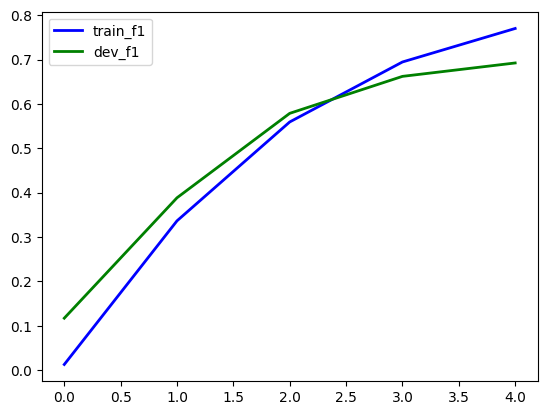

In [23]:
# Візуалізуємо навчальну й валідаційну метрики.
df = pd.DataFrame({'epochs': range(0,len(train_f)),
                  'train_f1': train_f,
                   'dev_f1': dev_f})

plt.plot('epochs', 'train_f1', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f1', data=df, color='green', linewidth=2)
plt.legend()
plt.show()

Бачимо, що модель є дещо перенавченою. Водночас результат на валідаційному наборі даних має місце до покращення.

Ми розглянемо детальніше, як впоратися з такими ситуаціями, на останньому занятті, присвяченому методам оптимізації.

In [24]:
# Перевіримо якість моделі на тестовому наборі даних. Завантажимо кращу зі збережених моделей.
tagger = torch.load(OUTPUT_PATH)

In [25]:
# Виконаємо перевірку.
labels = list(label2id.keys())[1:]
label_idxs = list(label2id.values())[1:]

test(tagger, test_loader, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

       B-PER       0.89      0.60      0.72      1617
       I-PER       0.91      0.71      0.79      1156
       B-ORG       0.77      0.62      0.69      1661
       I-ORG       0.69      0.72      0.70       835
       B-LOC       0.90      0.74      0.81      1668
       I-LOC       0.73      0.59      0.66       257
      B-MISC       0.68      0.63      0.65       702
      I-MISC       0.63      0.56      0.60       216

   micro avg       0.81      0.66      0.73      8112
   macro avg       0.77      0.65      0.70      8112
weighted avg       0.82      0.66      0.73      8112



Загалом модель показала непоганий результат. Бачимо, що вона є більш precosion-орієнтованою. Тобто ми рідше передбачаємо значення false positive — не класифікуємо значення як такі, що належать до класу, коли вони насправді не належать. Тобто ми не робимо помилкових передбачень.


Однак у цій задачі важливішим було б мати високий recall, оскільки нас цікавить низький показник false negatives — значень, які мали бути передбачені як представники класу, але не передбачені моделлю. Тобто зараз модель пропускає певні іменовані сутності й позначає їх як O.



Загалом можемо сказати, що якість моделі є задовільною, враховуючи, що архітектура нейронної мережі складається з мінімальної кількості компонент.